In [34]:
import torch
import torchvision.models as models
import numpy as np
import cv2

import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt

In [35]:
#set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#load imgs
img_l = cv2.imread('viprectification_deskLeft.png')
img_r = cv2.imread('viprectification_deskRight.png')

In [36]:
def load_resnet_feature_extractor():
    #model = models.resnet50(pretrained=True)  # Ensure you have pretrained=True or similar arguments based on your setup
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    # Remove the last layer to convert it into a feature extractor
    model = nn.Sequential(*list(model.children())[:-1])
    model.eval()  # Set the model to evaluation mode
    return model

In [37]:
# load model 
model = load_resnet_feature_extractor()

In [38]:
# create orb 
'''
orb = cv2.ORB_create()

# Detect keypoints and compute descriptors
keypointsL, descL = orb.detectAndCompute(img_l, None)
keypointsR, descR = orb.detectAndCompute(img_r, None)
'''
#sift = cv2.SIFT_create()
sift = cv2.ORB_create()
keyL, descL = sift.detectAndCompute(img_l, None)
keyR, descR = sift.detectAndCompute(img_r, None)

In [39]:
# padding images so as to get 8x8 that not 
imgl_shape = img_l.shape
imgr_shape = img_r.shape
img_pad_l = np.zeros((imgl_shape[0]+8,imgl_shape[1]+8,imgl_shape[2]))
img_pad_r = np.zeros((imgr_shape[0]+8,imgr_shape[1]+8,imgr_shape[2]))
img_pad_l[4:imgl_shape[0]+4,4:imgl_shape[1]+4,:] = img_l[:,:,:]
img_pad_r[4:imgr_shape[0]+4,4:imgr_shape[1]+4,:] = img_r[:,:,:]
print(img_l.shape)

(300, 400, 3)


In [40]:
def getPatchesbyKeyPoints(img, shape, keypoints):
    n = len(keypoints)
    z = torch.randn([n,3,8,8])
    z = z*0
    H = shape[0]
    W = shape[1]
    img_pad_l = transforms.ToTensor()(img)/255
    img_pad_l = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img_pad_l)
    for i in range(n):
        x = int(keypoints[i].pt[0])
        y = int(keypoints[i].pt[1])
        if x>=0 and x<H and y>=0 and y<W:
            try:
                z[i,:,:,:] = img_pad_l[:,x:x+8,y:y+8]
            except:
                print(x,y,x+8,y+8, H,W)
                break
    return z

In [41]:
patches_L = getPatchesbyKeyPoints(img_pad_l,img_l.shape, keyL)
patches_R = getPatchesbyKeyPoints(img_pad_r, img_r.shape,keyR)

In [42]:
features_L = model(patches_L).squeeze(-1).squeeze(-1)
features_R = model(patches_R).squeeze(-1).squeeze(-1)

In [43]:
npfeatures_L =features_L.cpu().detach().numpy()
npfeatures_R =features_R.cpu().detach().numpy()

def feature_matches(features_L,features_R):
    n = features_L.shape[0]
    dim = features_L.shape[1]
    m = features_R.shape[0]
    one = np.ones((m,1))
    retidx = []
    for i in range(n):
        feature = np.reshape(features_L[i,:],(1,dim))
        rep_feature = one@feature
        simlirity = np.sum(rep_feature*features_R,axis=1)
        idx = simlirity.argmax()
        retidx.append((i,idx, simlirity[idx]))
    return retidx

In [44]:
retidx = feature_matches(npfeatures_L, npfeatures_R)
retidx.sort(key=lambda a: a[2],reverse = True)

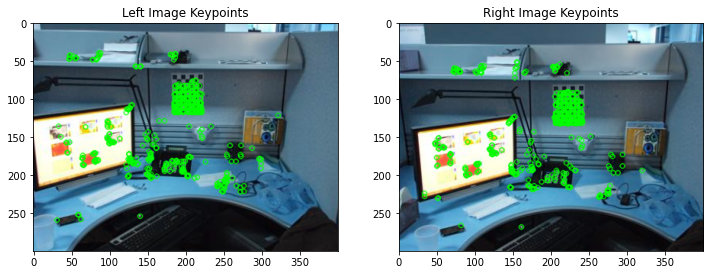

In [45]:
img_left_keypoints = cv2.drawKeypoints(img_l, keyL, None, color=(0, 255, 0))
img_right_keypoints = cv2.drawKeypoints(img_r, keyR, None, color=(0, 255, 0))

# Display keypoints
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Left Image Keypoints')
plt.imshow(img_left_keypoints)
plt.subplot(1, 2, 2)
plt.title('Right Image Keypoints')
plt.imshow(img_right_keypoints)
plt.show()


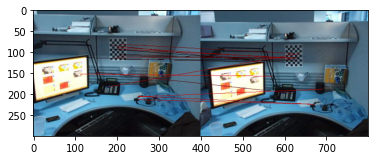

In [46]:
def drawMatches(matches, imag_L, imag_R, keyL, keyR):
    new_image = np.zeros((imag_R.shape[0],imag_L.shape[1]+imag_L.shape[1] ,3))
    new_image[0::,0:imag_L.shape[1],:] =imag_L[:,:,:]
    new_image[:,imag_L.shape[1]::,:] =imag_R[:,:,:]
    new_image = new_image.astype(np.uint8)
    L = 255/(len(matches))
    i=0
    for ele in matches:
        lidx = ele[0]
        ridx = ele[1]
        pt1 = (int(keyL[lidx].pt[0]), int(keyL[lidx].pt[1]))
        pt2 = (int(keyR[ridx].pt[0])+ imag_L.shape[1], int(keyR[ridx].pt[1])  )
        cv2.line(new_image, pt1,pt2, int(L)*i, 1)
        i+=1
    plt.imshow(new_image)
showidx = []
L = len(retidx)//15
for i in range(len(retidx)):
    if i%L==0:
        showidx.append(retidx[i])
#drawMatches(retidx[0:10], img_l,img_r,keyL,keyR)
drawMatches(showidx, img_l,img_r,keyL,keyR)

In [47]:
def calc_F(xr,yr, xl,yl):
    A = np.zeros((8,9))
    # img1 x' y' x y im2
    for i in range(8):
        A[i][0] = xr[i]*xl[i]
        A[i][1] = yr[i]*xl[i]
        A[i][2] = xl[i]
        A[i][3] = yl[i]*xr[i]
        A[i][4] = yl[i]*yr[i]
        A[i][5] = yl[i]
        A[i][6] = xr[i]
        A[i][7] = yr[i]
        A[i][8] = 1.0  
    
    _,_,v = np.linalg.svd(A)
    # print("v", v)
    f_vec = v.transpose()[:,8]
    # print("f_vec = ", f_vec)
    f_hat = np.reshape(f_vec, (3,3))
    # print("Fmat = ", f_hat)

    # Enforce rank(F) = 2 
    s,v,d = np.linalg.svd(f_hat)
    f_hat = s @ np.diag([*v[:2], 0]) @ d

    return f_hat

In [48]:
def Sampson_distance(F, XR, XL,N):
    b = XL.T@F@XR
    sums = 0
    for i in range(N):
        b = XL[:,i].T@F@XR[:,i]
        FXL = np.linalg.norm(F.T@XL[:,i],2)
        FXR = np.linalg.norm(F@XR[:,i],2)
        norm = FXL*FXL + FXR*FXR
        b = b*b/norm
        sums+=b
    return sums

In [49]:
N = len(retidx)
XR = np.ones((3,N))
XL = np.ones((3,N))
for i in range(N):
    lidx = retidx[i][0]
    ridx = retidx[i][1]
    XR[0,i] = keyR[ridx].pt[0]
    XR[1,i] = keyR[ridx].pt[1]

    XL[0,i] = keyL[lidx].pt[0]
    XL[1,i] = keyL[lidx].pt[1]

In [50]:
N = len(retidx)
Fundamental_Matrixs = []
Fundamental_Matrixs_errors = []
nidxs = []
nMatrix = 20
for i in range(nMatrix):
    idxs = np.random.choice(N, 8, replace=False)
    nidxs.append(nidxs)
    xl = np.zeros((8,1))
    yl = np.zeros((8,1))
    xr = np.zeros((8,1))
    yr = np.zeros((8,1))
    for j in range(8):
        lidx = retidx[idxs[j]][0]
        ridx = retidx[idxs[j]][1]
        xl[j] = keyL[lidx].pt[0]
        yl[j] = keyL[lidx].pt[1]
        xr[j] = keyR[ridx].pt[0]
        yr[j] = keyR[ridx].pt[1]
    F = calc_F(xr,yr, xl,yl)
    errF = Sampson_distance(F, XR, XL, N)
    Fundamental_Matrixs.append(F)
    Fundamental_Matrixs_errors.append(errF)

/tmp/ipykernel_31008/2814333339.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A[i][0] = xr[i]*xl[i]
/tmp/ipykernel_31008/2814333339.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A[i][1] = yr[i]*xl[i]
/tmp/ipykernel_31008/2814333339.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A[i][2] = xl[i]
/tmp/ipykernel_31008/2814333339.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

In [51]:
Fundamental_Matrixs_errors = np.array(Fundamental_Matrixs_errors)

In [52]:
min_idx = Fundamental_Matrixs_errors.argmin()

In [53]:
print(Fundamental_Matrixs[0])

[[ 1.35872686e-05  1.72399719e-06 -3.19258259e-03]
 [ 1.75493370e-05  6.11102265e-07 -3.96943048e-03]
 [-4.36494091e-03 -2.84974831e-04  9.99977458e-01]]


In [54]:
print(Fundamental_Matrixs[min_idx])

[[ 2.60827632e-05  1.37308554e-06 -6.19729987e-03]
 [-1.04251995e-05  4.39786733e-07  2.36434058e-03]
 [-4.08294235e-03 -4.76842757e-04  9.99969552e-01]]


In [55]:
computed_sampson_distance = Sampson_distance(F, XR, XL, N)
mean_sampson_distance = np.mean(computed_sampson_distance)
print("Mean Sampson Distance", mean_sampson_distance)

Mean Sampson Distance 7.132759709385333


# Using Packages - OpenCV

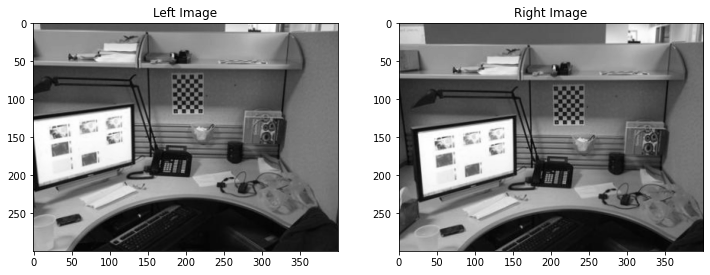

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load stereo images
img_left = cv2.imread('viprectification_deskLeft.png', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('viprectification_deskRight.png', cv2.IMREAD_GRAYSCALE)

# Display images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Left Image')
plt.imshow(img_left, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Right Image')
plt.imshow(img_right, cmap='gray')
plt.show()

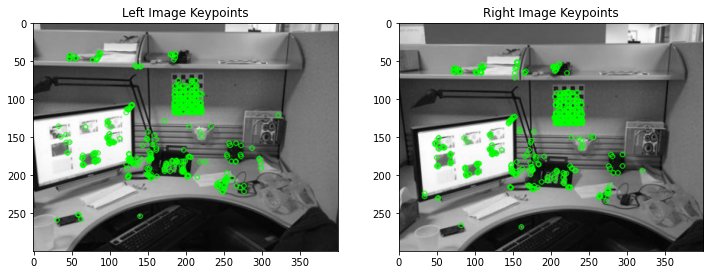

In [57]:
# Initialize ORB detector
orb = cv2.ORB_create()

# Detect keypoints and compute descriptors
keypoints_left, descriptors_left = orb.detectAndCompute(img_left, None)
keypoints_right, descriptors_right = orb.detectAndCompute(img_right, None)

# Draw keypoints
img_left_keypoints = cv2.drawKeypoints(img_left, keypoints_left, None, color=(0, 255, 0))
img_right_keypoints = cv2.drawKeypoints(img_right, keypoints_right, None, color=(0, 255, 0))

# Display keypoints
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Left Image Keypoints')
plt.imshow(img_left_keypoints)
plt.subplot(1, 2, 2)
plt.title('Right Image Keypoints')
plt.imshow(img_right_keypoints)
plt.show()

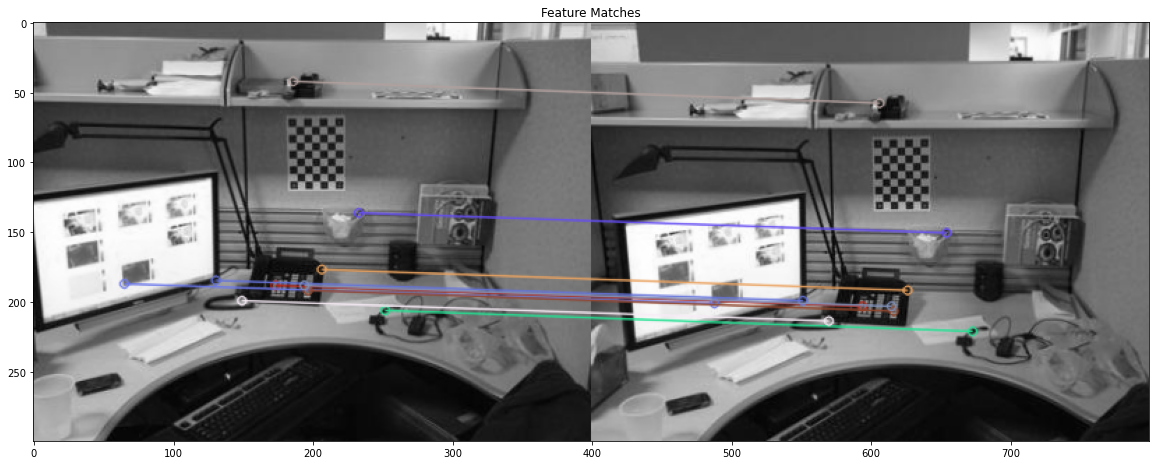

In [58]:
# Initialize BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors_left, descriptors_right)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw top matches
img_matches = cv2.drawMatches(img_left, keypoints_left, img_right, keypoints_right, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display matches
plt.figure(figsize=(20, 10))
plt.imshow(img_matches)
plt.title('Feature Matches')
plt.show()


In [59]:
# Extract location of good matches
points_left = np.zeros((len(matches), 2), dtype=np.float32)
points_right = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points_left[i, :] = keypoints_left[match.queryIdx].pt
    points_right[i, :] = keypoints_right[match.trainIdx].pt

# Normalize points
points_left_mean = np.mean(points_left, axis=0)
points_right_mean = np.mean(points_right, axis=0)

points_left -= points_left_mean
points_right -= points_right_mean

# Scale points to have an average distance of sqrt(2) from the origin
points_left_scale = np.sqrt(2) / np.mean(np.linalg.norm(points_left, axis=1))
points_right_scale = np.sqrt(2) / np.mean(np.linalg.norm(points_right, axis=1))

points_left *= points_left_scale
points_right *= points_right_scale

# Construct the matrix A for the 8-point algorithm
A = np.zeros((len(matches), 9))
for i in range(len(matches)):
    x1, y1 = points_left[i, 0], points_left[i, 1]
    x2, y2 = points_right[i, 0], points_right[i, 1]
    A[i] = [x1 * x2, x1 * y2, x1, y1 * x2, y1 * y2, y1, x2, y2, 1]

# Compute the fundamental matrix using SVD
U, S, Vt = np.linalg.svd(A)
F = Vt[-1].reshape(3, 3)

# Enforce rank-2 constraint on F
U, S, Vt = np.linalg.svd(F)
S[2] = 0
F = np.dot(U, np.dot(np.diag(S), Vt))

# Denormalize the fundamental matrix
T_left = np.array([[points_left_scale, 0, -points_left_scale * points_left_mean[0]], 
                   [0, points_left_scale, -points_left_scale * points_left_mean[1]], 
                   [0, 0, 1]])
T_right = np.array([[points_right_scale, 0, -points_right_scale * points_right_mean[0]], 
                    [0, points_right_scale, -points_right_scale * points_right_mean[1]], 
                    [0, 0, 1]])
F = np.dot(T_right.T, np.dot(F, T_left))

print("Fundamental matrix F:")
print(F)

Fundamental matrix F:
[[-2.09162737e-06  5.94028806e-05 -1.43023141e-02]
 [-6.53975649e-05  4.00379249e-06 -2.98016776e-03]
 [ 1.71783724e-02  1.60525009e-03  1.46000384e-01]]


In [60]:
def compute_sampson_distance(F, points_left, points_right):
    ones = np.ones((points_left.shape[0], 1))
    points_left_hom = np.hstack((points_left, ones))
    points_right_hom = np.hstack((points_right, ones))

    Fx1 = np.dot(F, points_left_hom.T).T
    Ftx2 = np.dot(F.T, points_right_hom.T).T

    numerator = (np.sum(points_right_hom * Fx1, axis=1)) ** 2
    denominator = Fx1[:, 0] ** 2 + Fx1[:, 1] ** 2 + Ftx2[:, 0] ** 2 + Ftx2[:, 1] ** 2
    distance = numerator / denominator
    return distance

# Compute Sampson distance
sampson_distances = compute_sampson_distance(F, points_left, points_right)
mean_sampson_distance = np.mean(sampson_distances)

print("Mean Sampson Distance:", mean_sampson_distance)

Mean Sampson Distance: 41.75844364519403
